In [11]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

import torch
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn
from torch import optim
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import os

from joblib import Parallel, delayed
from Evolution.EvolutionaryLib import BaseChromosome, ChromosomeClassFactory

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Data preparation

In [12]:
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        return self.data[item][0], self.data[item][1]


classes = set(range(10))
train_size = 512
test_size = 64
train_batch_size = 16
test_batch_size = 8

CROP_SIZE = 32

In [13]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(CROP_SIZE)
])

train_data = datasets.CIFAR10(
    root='data',
    train=True,
    transform=transformer,
    download=True,
)
test_data = datasets.CIFAR10(
    root='data',
    train=False,
    transform=transformer,
    download=True,
)

train_indices = torch.cat([torch.where(torch.Tensor(train_data.targets) == c)[0][:train_size] for c in classes])
test_indices = torch.cat([torch.where(torch.Tensor(test_data.targets) == c)[0][:test_size] for c in classes])

train_data = torch.utils.data.Subset(train_data, train_indices)
test_data = torch.utils.data.Subset(test_data, test_indices)

train_dataset = MyDataset(train_data)
test_dataset = MyDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
class CNN(nn.Module):
    def __init__(self, kernel_structure: tuple[int], classifier_structure: tuple[int], n_channels: int,
                 out_classes: int):
        super(CNN, self).__init__()
        self.image_size = (CROP_SIZE, CROP_SIZE)
        self.kernel_structure = kernel_structure
        self.classifier_structure = classifier_structure
        cropped_img = (self.image_size[0] - sum(kernel_structure) + len(kernel_structure),
                       self.image_size[1] - sum(kernel_structure) + len(kernel_structure))
        self.cropped_img = cropped_img
        self.channels = n_channels

        # Convolutional part initialisation 
        architecture = [nn.Conv2d(in_channels=3, out_channels=self.channels, kernel_size=kernel_structure[0]),
                        nn.ReLU()]
        for kernel_size in kernel_structure[1:]:
            architecture.append(
                nn.Conv2d(in_channels=self.channels, out_channels=self.channels, kernel_size=kernel_size))
            architecture.append(nn.ReLU())

        self.convolve = nn.Sequential(
            *architecture
        )

        # CLassifier part initialisation 
        architecture = [nn.Linear(self.channels * cropped_img[0] * cropped_img[1], classifier_structure[0]), nn.ReLU()]
        for i in range(len(classifier_structure) - 1):
            architecture.append(nn.Linear(classifier_structure[i], classifier_structure[i + 1]))
            architecture.append(nn.ReLU())

        architecture.append(nn.Linear(classifier_structure[-1], out_classes))

        self.classifier = nn.Sequential(
            *architecture
        )

    def forward(self, x):
        x = self.convolve(x)
        x = self.classifier(x.view(-1, self.channels * self.cropped_img[0] * self.cropped_img[1]))
        return F.log_softmax(x, dim=1)


criterion = nn.CrossEntropyLoss()

In [15]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()

    for _ in range(epoch):
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            output = model(data).softmax(dim=1)

            loss = criterion(output, target)

            loss.backward()
            optimizer.step()


def test(model, device, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    return 100. * correct / len(test_loader.dataset)

In [16]:
class MyChromosome(BaseChromosome):
    def __init__(self):
        super().__init__()

    def crossover(self, other):
        new = MyChromosome()
        self.copy(new)

        new['kernel_structure'] = self._kernel_structure.crossover(other._kernel_structure)
        new['classifier_structure'] = self._classifier_structure.crossover(other._classifier_structure)

        new['lr'] = (self['lr'] + other['lr']) / 2
        new['epochs'] = random.choice([self['epochs'], other['epochs']])
        new['channels'] = random.choice([self['channels'], other['channels']])
        new['optimizer'] = random.choice([self['optimizer'], other['optimizer']])

        return new

    def mutate(self, rate=0.3):
        new = MyChromosome()
        self.copy(new)

        if random.random() < rate:
            new.kernel_structure = new._kernel_structure.mutate()
        else:
            new.kernel_structure = self.kernel_structure

        if random.random() < rate:
            new.classifier_structure = new._classifier_structure.mutate()
        else:
            new.classifier_structure = self.classifier_structure

        new.channels = new._channels.get() if random.random() < rate else self.channels
        new.optimizer = new._optimizer.get() if random.random() < rate else self.optimizer
        new.epochs = new._epochs.get() if random.random() < rate else self.epochs
        new.lr = new._lr.get() if random.random() < rate else self.lr

        return new


chromosome_factory = ChromosomeClassFactory(
    kernel_structure={'n': [2, 3, 4, 5, 6], 'range': [3, 5]},
    classifier_structure={'n': [1, 2, 3, 4, 5, 6], 'range': list(range(25, 100))},
    channels=list(range(1, 15)),
    optimizer=['sgd', 'adam', 'adagrad', 'rmsprop'],
    lr=(1e-7, 1),
    epochs=list(range(2, 25))
)

In [17]:
import torch.optim as optim


def evaluate(chromosome, show_metric=False):
    if chromosome.get_score() is not None:
        return chromosome.get_score()

    n_iterations = 1
    metric = 0

    for _ in range(n_iterations):
        model = CNN(chromosome.kernel_structure, chromosome.classifier_structure, chromosome.channels, len(classes)).to(
            device)

        if chromosome.optimizer == 'sgd':
            optimizer = optim.SGD(model.parameters(), lr=chromosome.lr)
        elif chromosome.optimizer == 'adam':
            optimizer = optim.Adam(model.parameters(), lr=chromosome.lr)
        elif chromosome.optimizer == 'adagrad':
            optimizer = optim.Adagrad(model.parameters(), lr=chromosome.lr)
        elif chromosome.optimizer == 'rmsprop':
            optimizer = optim.RMSprop(model.parameters(), lr=chromosome.lr)

        train(model, device, train_loader, optimizer, chromosome.epochs)
        metric += test(model, device, test_loader)

    metric /= n_iterations

    if show_metric:
        print(f'{metric=}')

    return metric

In [18]:
# evolution hyperparameters initialisation 
POPULATION_SIZE = 9
ITERATIONS = 7
best = None

In [9]:
statistic_best = []
statistic_mean = []

statistic_n_epochs = []
statistic_lr = []

statistic_kernel_size = []
statistic_n_kernel_layers = []
statistic_n_channels = []

statistic_n_neurons = []
statistic_n_layers = []

population = []
for _ in range(POPULATION_SIZE):
    c = chromosome_factory.generate(MyChromosome)
    population.append(c)

with Parallel(n_jobs=4) as parallel:
    for iteration in tqdm(range(ITERATIONS)):
        # scores = [evaluate(chromosome) for chromosome in population]
        scores = parallel(delayed(evaluate)(chromosome) for chromosome in population)
        for i, chromosome in enumerate(population):
            chromosome.set_score(scores[i])

        # selection of best instances 
        population = sorted(population, key=lambda x: x.get_score(), reverse=True)[:POPULATION_SIZE // 3]
        # check for the best solution 
        if best is None or population[0].get_score() > best.get_score():
            best = population[0]

        statistic_best.append(best.get_score())
        statistic_mean.append(sum(map(MyChromosome.get_score, population)) / POPULATION_SIZE)

        statistic_n_epochs.append(best.epochs)
        statistic_lr.append(best.lr)

        statistic_kernel_size.append(sum(best.kernel_structure) / len(best.kernel_structure))
        statistic_n_kernel_layers.append(len(best.kernel_structure))
        statistic_n_channels.append(best.channels)

        statistic_n_neurons.append(sum(best.classifier_structure))
        statistic_n_layers.append(len(best.classifier_structure))

        # filling the population with new genes 
        while len(population) < POPULATION_SIZE:
            r = random.random()
            if r < 0.33:
                population.append(random.choice(population).crossover(random.choice(population)))
            elif 0.33 <= r < 0.66:
                population.append(random.choice(population).mutate())
            else:
                population.append(chromosome_factory.generate(MyChromosome))
    else:
        # scores = [evaluate(chromosome) for chromosome in population]
        scores = parallel(delayed(evaluate)(chromosome) for chromosome in population)
        for i, chromosome in enumerate(population):
            chromosome.set_score(scores[i])

  0%|          | 0/7 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [163]:
# 4:11
print(best)

--Chromosome--
score: 22.8125
kernel_structure: (5, 5, 3)
classifier_structure: (99, 80)
channels: 2
optimizer: sgd
lr: 0.10474265155215089
epochs: 10



In [161]:
import pickle

for i, ch in enumerate(population):
    ps = pickle.dumps(ch)

    with open(f'chromosomes/channels_{i}.txt', mode='wb') as file:
        ps = pickle.dumps(ch)
        file.write(ps)

# for i in range(30): 
#     ch_loaded = pickle.loads(open(f'chromosomes/{i}.txt', mode='rb').read())
#     print(ch_loaded)

--Chromosome--
score: 10.0
kernel_structure: (5, 3, 5)
classifier_structure: (78,)
channels: 12
optimizer: rmsprop
lr: 0.3107163785995188
epochs: 10



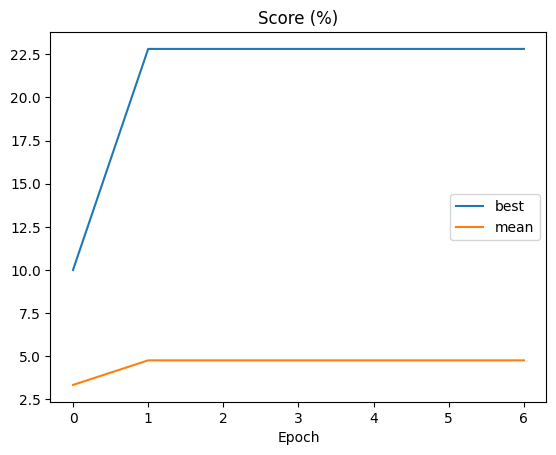

In [162]:
import matplotlib.pyplot as plt

print(chromosome)
plt.title("Score (%)")
plt.xlabel("Epoch")
plt.plot(statistic_best, label='best')
plt.plot(statistic_mean, label='mean')
plt.legend()
plt.show()